In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
import grad_lib
import importlib
importlib.reload(grad_lib)
from grad_lib import Tensor, ReLU, FeedForward, Softmax, LinearLayer, Log, DataSet 

In [3]:
from sklearn.datasets import load_digits

In [4]:
data=load_digits()
imgs=data['data']
target=data['target']

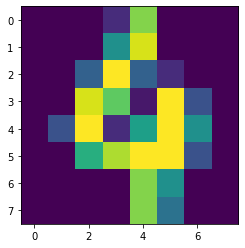

In [5]:
plt.imshow(imgs[100].reshape(8,8))

In [6]:
img_norm=imgs/16

In [97]:
class ConvNet2D:
    def __init__(self,kernel_size,img_size=(8,8),stride=1,padding=0):
        """Convolutional Layer with 2D kernel

        Args:
            kernel_size ([type]): [description]
            img_size (tuple, optional): [description]. Defaults to (8,8).
            stride (int, optional): [description]. Defaults to 1.
            padding (int, optional): [description]. Defaults to 0.
        """
        self.img_size=img_size
        self.stride=stride
        self.pad=padding
        self.kernel_shape=(kernel_size,kernel_size)

        weight, bias=self.init_param()
        self.kernel=Tensor(weight.reshape(1,-1),requires_grad=True)
        self.bias=Tensor(bias,requires_grad=True)

        self.out_dim=self.get_out_dim()
        self.relu=ReLU()

        """trainable Tensors
        """
        self.trainable={id(self.kernel): self.kernel,
                        id(self.bias): self.bias
                        }
    
    def __call__(self,x):
        """forward

        Args:
            x (Tensor): (batch,S,S)

        Returns:
            Tensor: (batch,num_neurons)
        """
        x_tensor=self.transform(x.array)
        out=self.kernel*x_tensor+self.bias
        out=self.relu(out)

        return out.squeeze(0) 

    def init_param(self):
        weight=np.random.normal(0,1,self.kernel_shape)
        bias=np.random.normal(0,1,(1,1))

        return weight, bias 

    def transform(self,x):
        """transform batch of images

        Args:
            x (numpy.array): (batch,S,S)

        Returns:
            Tensor: (kernel_size**2,batch,num_neurons)
        """
        # x: array
        i_f=x.shape[1]+self.pad-self.kernel_shape[0]
        j_f=x.shape[2]+self.pad-self.kernel_shape[1]

        out_list=[]
        for k in range(x.shape[0]):
            out=np.zeros((1,self.kernel_shape[0]*self.kernel_shape[1]))
            for i in range(0,i_f+1,self.stride):
                for j in range(0,j_f+1,self.stride):
                    z=x[k,i:i+self.kernel_shape[0],j:j+self.kernel_shape[1]].reshape(1,-1)
                    out=np.concatenate([out,z],axis=0)
            out_list.append(out[1:])
        
        #out_list: [batch,num_neurons,kernel_size**2]
        out=np.array(out_list).transpose(2,0,1)
        return Tensor(out,requires_grad=False)

    def get_out_dim(self):
        test=np.zeros((1,self.img_size[0],self.img_size[1]))
        size=self.transform(test).shape

        return size[2]

In [60]:
class ConvClassifier:
    def __init__(self,img_size,hidden_dim,out_dim=1):
        """Convolutional Neural Network Classifier

        Args:
            img_size (tuple): (width,height)
            hidden_dim (int): number of hidden neurons
            out_dim (int, optional): number of class. Defaults to 1.
        """
        self.convnet=ConvNet2D(kernel_size=3,img_size=img_size)
        in_dim=self.convnet.out_dim
        self.in_layer=LinearLayer(in_dim,hidden_dim)
        self.out_layer=LinearLayer(hidden_dim,out_dim)
        self.softmax=Softmax()
        self.relu=ReLU()

    def __call__(self,x):
        """[summary]

        Args:
            x (numpy.array): input must be array, not Tensor

        Returns:
            probability: (batch,out_dim)
        """
        out=self.convnet(x)
        out=self.in_layer(out)
        out=self.relu(out)
        out=self.out_layer(out)
        prob=self.softmax(out)

        return prob
        
    @staticmethod
    def train():
        Tensor.calc_grad=True
    @staticmethod
    def eval():
        Tensor.calc_grad=False 

In [43]:
class CrossEntropyLoss:
    def __init__(self,model):
        self.model=model
        self.log=Log()

    def __call__(self,prob,y):
        """loss function

        Args:
            prob (probability Tensor): (batch,num_classes)
            y (array): (batch,1)
        """
        bsz=y.shape[0]
        prob_=prob[range(bsz),y[:,0]]
        loss=-self.log(prob_).sum(0)
        loss=(1/bsz)*loss 

        self.back_grads=loss.grad

        return loss.array
    
    def backward(self):
        self.model.grads=self.back_grads

class Optimizer:
    def __init__(self,model,lr):
        self.model=model 
        self.lr=lr

        self.tensors={}
        for _,obj in self.model.__dict__.items():
            if hasattr(obj,'trainable'):
                self.tensors.update(obj.trainable)
    
    def zero_grad(self):
        for idx, tensor in self.tensors.items():
            if tensor.requires_grad:
                grad={}
                grad[idx]=tensor.grad[idx]
                tensor.grad=grad
            else:
                grad={'none':0}
                tensor.grad=grad 

    def step(self):
        if self.model.grads is not None:
            for idx, tensor in self.tensors.items():
                if idx in self.model.grads:
                    tensor.array-=self.lr*self.model.grads[idx]
        else:
            print('No grads!')

In [11]:
img_norm=img_norm.reshape(img_norm.shape[0],8,8)

In [14]:
target=target.reshape(-1,1)

In [55]:
data_loader=DataSet(img_norm,target,batch_size=64)

In [129]:
model=ConvClassifier(img_size=(8,8),hidden_dim=10,out_dim=10)
loss=CrossEntropyLoss(model)
opt=Optimizer(model,lr=0.1)

In [160]:
model.train()
for epoch in range(10):
    total_loss=0
    L=len(data_loader)
    
    for batch in data_loader:
        batch_x,batch_y=batch
        bsz=batch_x.shape[0]

        opt.zero_grad()
        pred=model(batch_x)
        total_loss+=loss(pred,batch_y.array)*bsz
        loss.backward()
        opt.step()
    
    print('Epoch: ',epoch," Loss: ",total_loss/L)



Epoch:  0  Loss:  0.24006336416935398
Epoch:  1  Loss:  0.23706346343190177
Epoch:  2  Loss:  0.23474814745681546
Epoch:  3  Loss:  0.23181012010388796
Epoch:  4  Loss:  0.2284283643923965
Epoch:  5  Loss:  0.22631450659598182
Epoch:  6  Loss:  0.22454756532273396
Epoch:  7  Loss:  0.22214245742829636
Epoch:  8  Loss:  0.21969947021708777
Epoch:  9  Loss:  0.21809637837201185


In [161]:
model.train()
acc=0
for batch in data_loader:
    batch_x,batch_y=batch

    pred=model(batch_x)
    out=pred.array.argmax(1).reshape(-1,1)
    acc+=(out==batch_y.array).sum().astype('int')

print(acc/len(data_loader))

0.9271007234279355
